In [ ]:
import torch
from models import MAEModel

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

model = MAEModel(img_size=96, patch_size=8, enc_dim=192, mask_ratio=0.75)
model.encoder.load_state_dict(torch.load('mae_stl10_encoder_192_37_last.pth'))
model.decoder.load_state_dict(torch.load('mae_stl10_decoder_192_37_last.pth'))

transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.4467, 0.4398, 0.4066],
                                std=[0.2241, 0.2215, 0.2239]),
                                ])

ds = datasets.STL10(root='../data', split='test', download=True,
                                    transform=transform)

import torch
import random
import matplotlib.pyplot as plt
from utils.shuffle import patchify, unpatchify


def denormalize(img, mean, std):
    """
    img: (3, H, W)
    """
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean


def visualize_mae(
    model,
    dataset,
    device="cuda",
    num_samples=10,
    img_size=96,
    patch_size=8,
    mean=[0.4467, 0.4398, 0.4066],
    std=[0.2241, 0.2215, 0.2239],
):
    model.eval()
    model.to(device)

    idxs = random.sample(range(len(dataset)), num_samples)
    imgs = torch.stack([dataset[i][0] for i in idxs]).to(device)  # (B,3,H,W)

    with torch.no_grad():
        pred, mask = model(imgs)

        tgt = patchify(imgs, patch_size)  # (B, n_patches, patch_dim)

        # 1) unmasked only (encoder sees)
        unmasked_patches = tgt * (1 - mask.unsqueeze(-1))
        unmasked_img = unpatchify(unmasked_patches, img_size)
        # 2) reconstruction full (MAE standard)
        recon_full_patches = tgt * (1 - mask.unsqueeze(-1)) + pred * mask.unsqueeze(-1)
        recon_full_img = unpatchify(recon_full_patches, img_size)

    # ===== plot =====
    fig, axes = plt.subplots(3, num_samples, figsize=(2 * num_samples, 6))

    for i in range(num_samples):
        input = denormalize(imgs[i].cpu(), mean, std).clamp(0, 1)
        unmask  = denormalize(unmasked_img[i].cpu(), mean, std).clamp(0, 1)
        recon  = denormalize(recon_full_img[i].cpu(), mean, std).clamp(0, 1)

        axes[0, i].imshow(input.permute(1, 2, 0))
        axes[1, i].imshow(unmask.permute(1, 2, 0))
        axes[2, i].imshow(recon.permute(1, 2, 0))
        for r in range(3):
            axes[r, i].axis("off")

    axes[0, 0].set_ylabel("Input", fontsize=12)
    axes[1, 0].set_ylabel("Recon only", fontsize=12)
    axes[2, 0].set_ylabel("Recon full", fontsize=12)

    plt.tight_layout()
    plt.show()


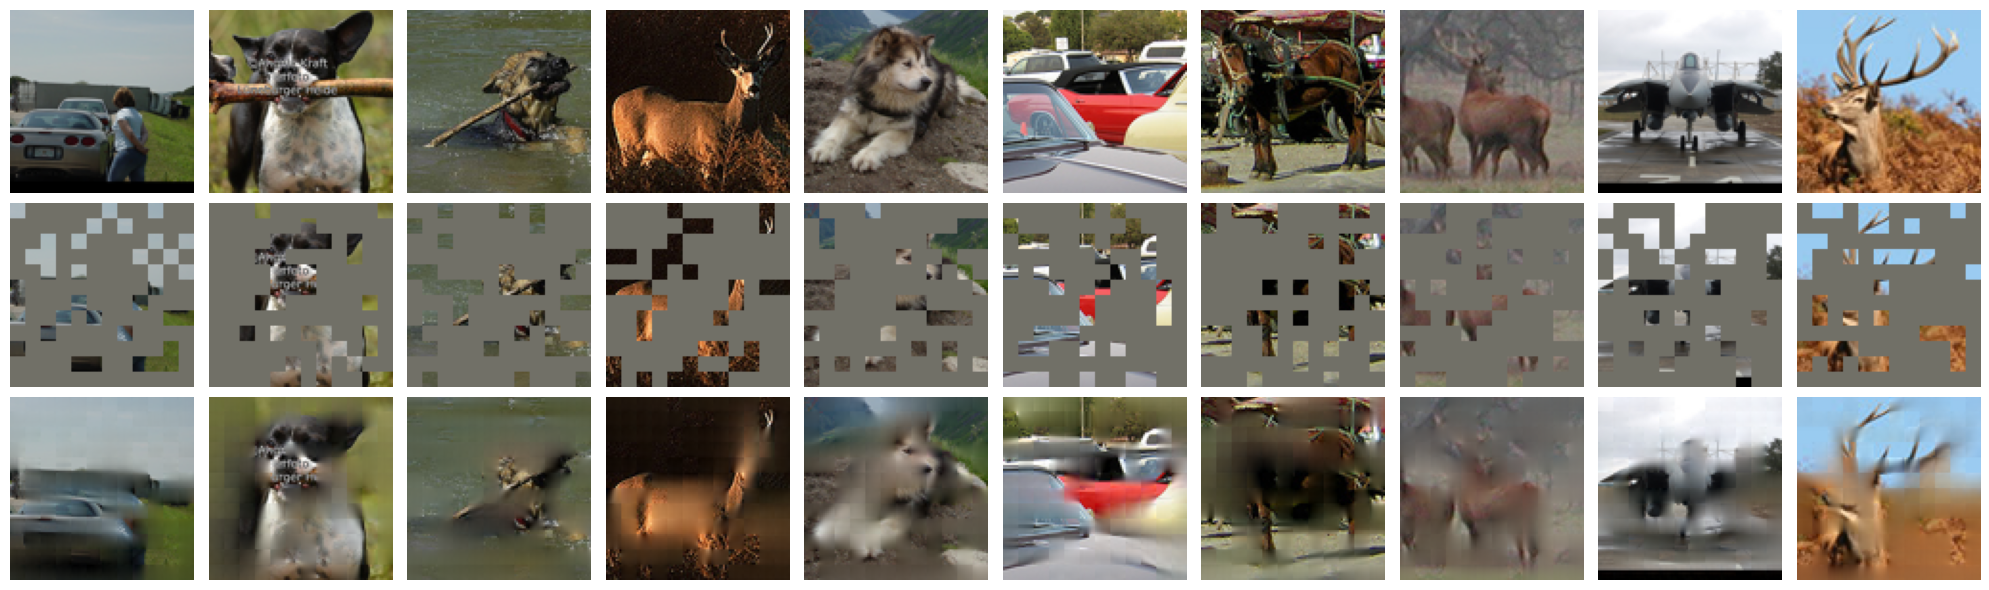

In [17]:
visualize_mae(model, ds, device="cuda", num_samples=10, img_size=96, patch_size=8)

Loading MNIST to memory...
Loaded 60000 Train images and 10000 Test images to cuda


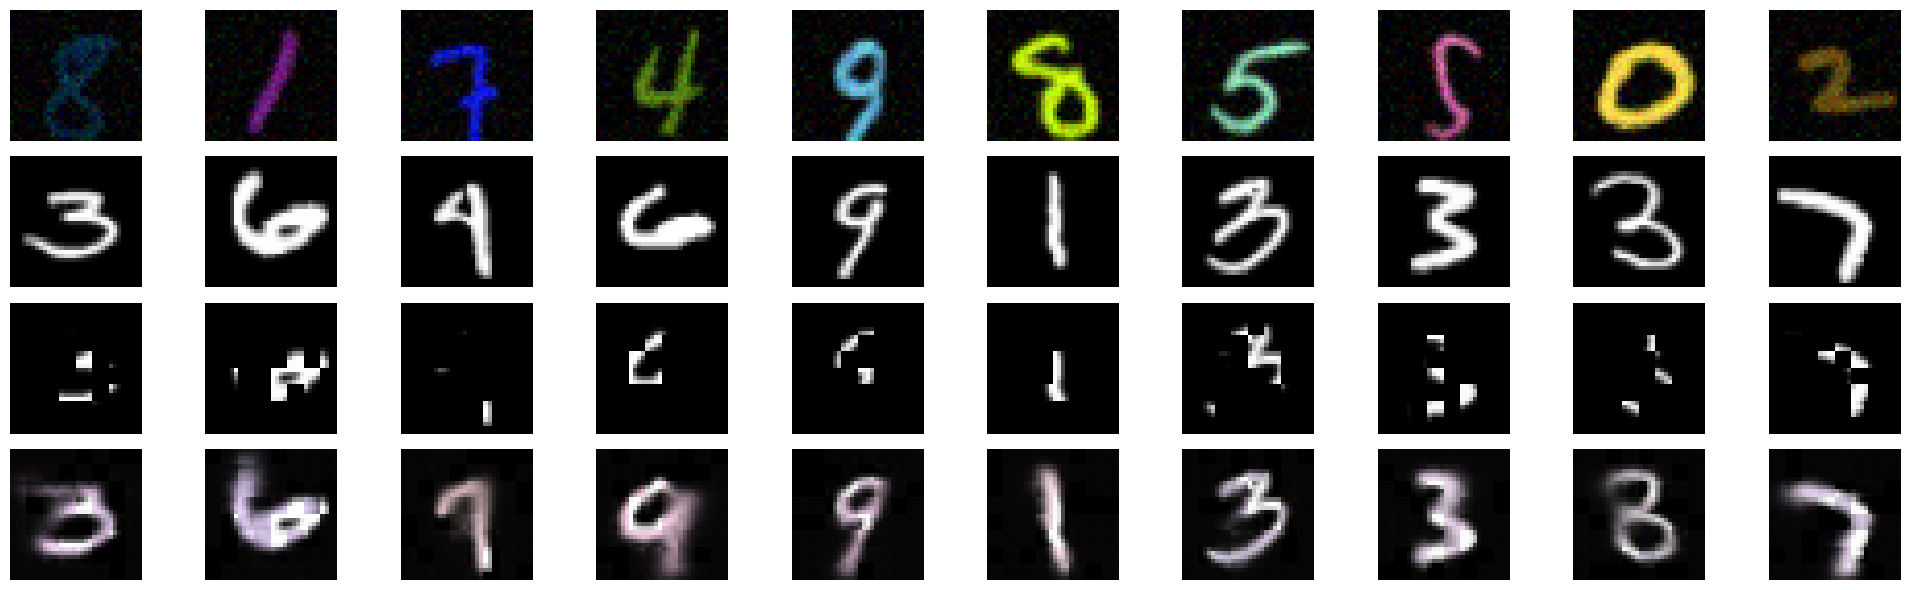

Loading FashionMNIST to memory...
Loaded 60000 Train images and 10000 Test images to cuda


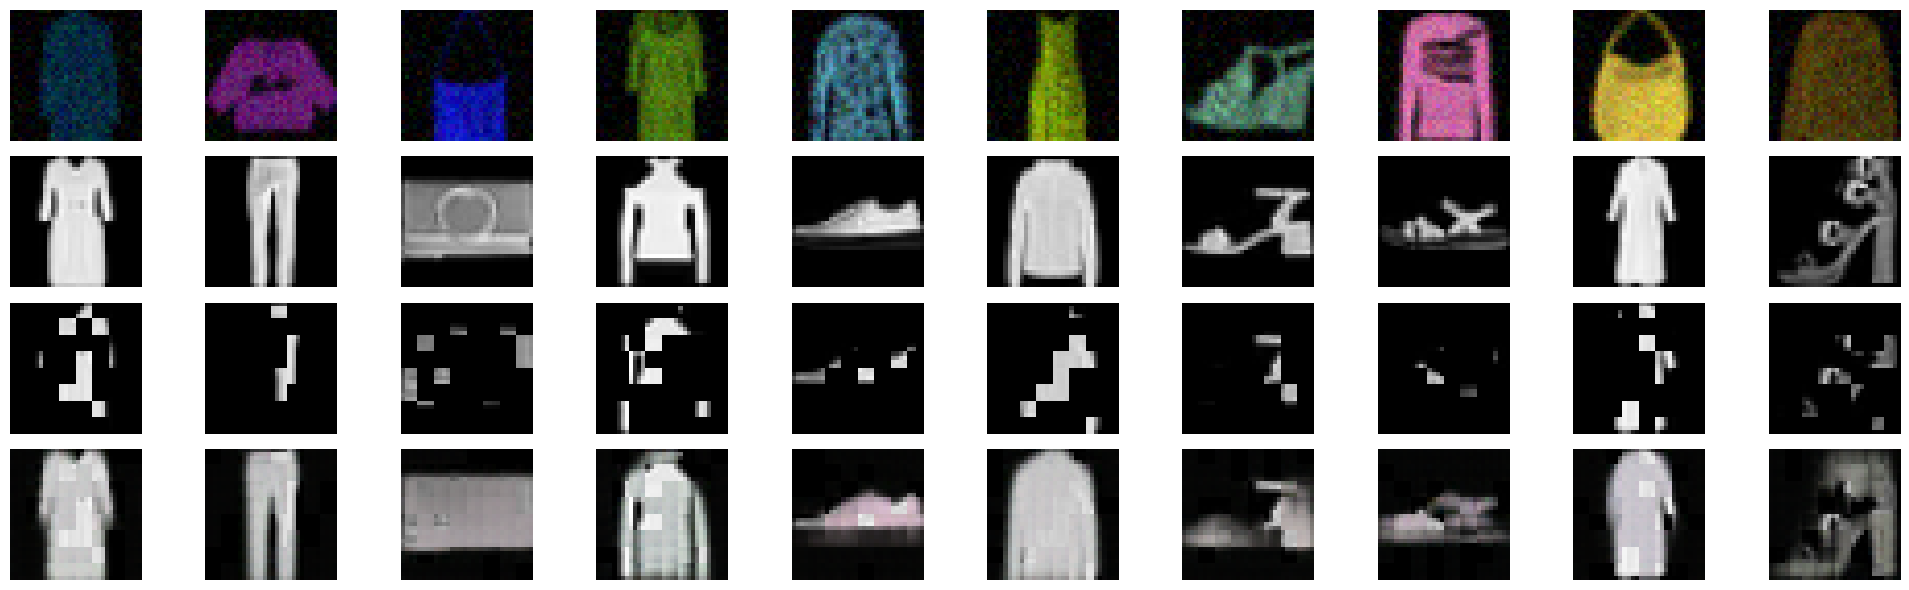

Loading CIFAR-10 to memory...
Loaded 50000 Train images and 10000 Test images to cuda


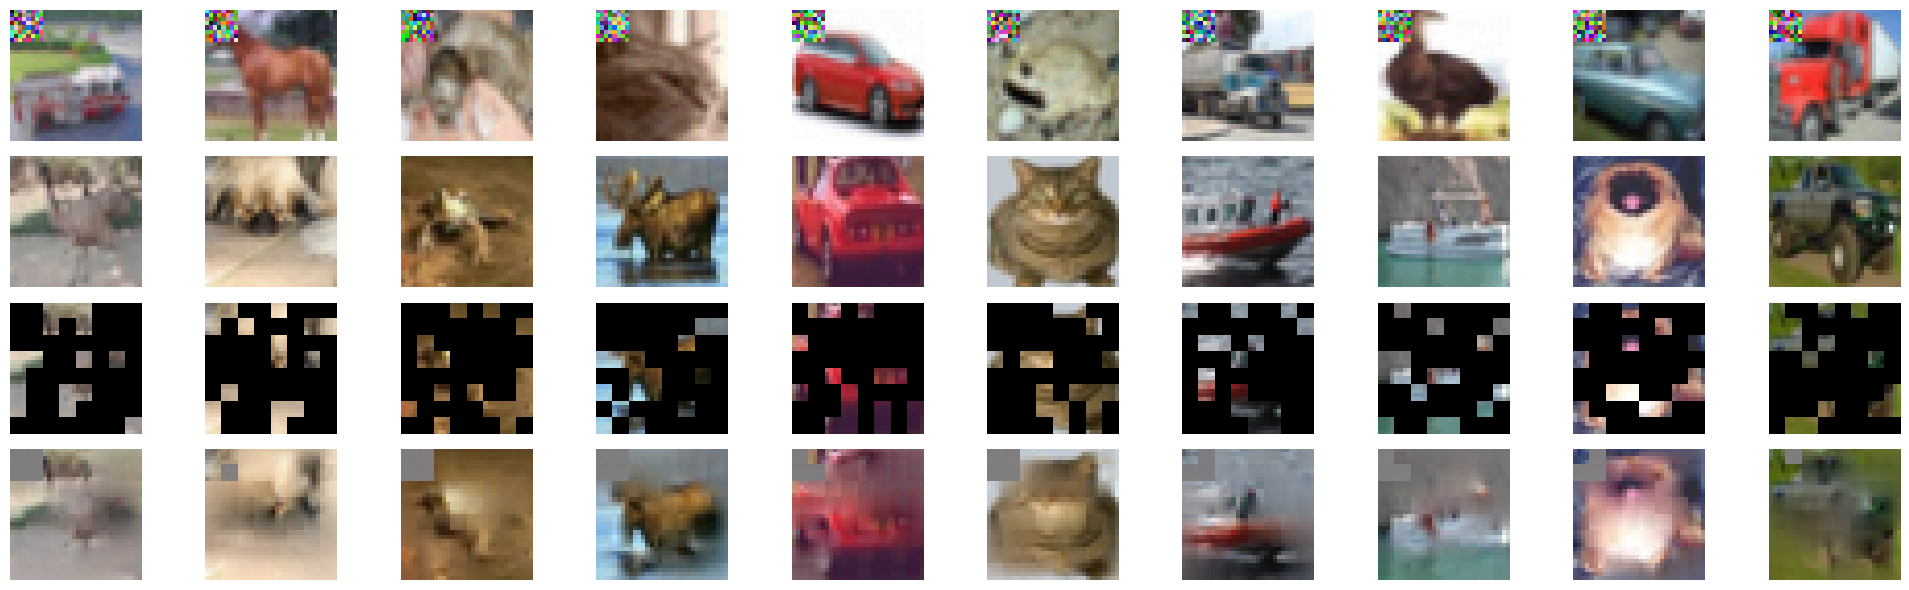

In [ ]:
import torch
from models import MAEModel
import random
import matplotlib.pyplot as plt
from utils.shuffle import patchify, unpatchify

from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from loaders_wm import ColoredMNISTLoader, ColoredFMNISTLoader, PatchedCIFARLoader

tasks = ['mnist', 'fmnist', 'cifar10']
device = 'cuda' if torch.cuda.is_available() else 'cpu'
for task in tasks:

    model = MAEModel(img_size=32, patch_size=4, enc_dim=192, mask_ratio=0.75)
    model.encoder.load_state_dict(torch.load(f'./ckpt/mae_{task}_wm_encoder_192_37_last.pth'))
    model.decoder.load_state_dict(torch.load(f'./ckpt/mae_{task}_wm_decoder_192_37_last.pth'))

    class GrayToRGB:
            def __call__(self, x):
                # x: (1, H, W)
                return x.repeat(3, 1, 1)

    if 'mnist' in task:
        transform = transforms.Compose([
                    transforms.Resize(32),
                    transforms.ToTensor(),
                    GrayToRGB(),
                                        ])
        if task == 'mnist':
            ds = datasets.MNIST(root='../data', train=False, download=True,
                                        transform=transform)
            loader = ColoredMNISTLoader(batch_size=10, device=device)
        elif task == 'fmnist':
            ds = datasets.FashionMNIST(root='../data', train=False, download=True,
                                        transform=transform)
            loader = ColoredFMNISTLoader(batch_size=10, device=device)
    elif task == 'cifar10':

        transform = transforms.Compose([
                    transforms.ToTensor(),
        ])
        ds = datasets.CIFAR10(root='../data', train=False, download=True,
                                            transform=transform)
        loader = PatchedCIFARLoader(batch_size=10, device=device)
    else:
        raise NotImplementedError(f"Dataset {task} not supported")


    def denormalize(img, mean, std):
        """
        img: (3, H, W)
        """
        mean = torch.tensor(mean).view(3, 1, 1)
        std = torch.tensor(std).view(3, 1, 1)
        return img * std + mean


    def visualize_mae_cifar(
        model,
        dataset,
        device="cuda",
        num_samples=10,
        img_size=96,
        patch_size=8,
        mean=[0.4467, 0.4398, 0.4066],
        std=[0.2241, 0.2215, 0.2239],
    ):
        model.eval()
        model.to(device)

        
        idxs = random.sample(range(len(dataset)), num_samples)
        imgs = torch.stack([dataset[i][0] for i in idxs]).to(device)  # (B,3,H,W)
        org = loader._process_batch(imgs,)
        org = org[:10]

        with torch.no_grad():
            pred, mask = model(imgs)

            tgt = patchify(imgs, patch_size)  # (B, n_patches, patch_dim)

            # 1) unmasked only (encoder sees)
            unmasked_patches = tgt * (1 - mask.unsqueeze(-1))
            unmasked_img = unpatchify(unmasked_patches, img_size)
            # 2) reconstruction full (MAE standard)
            recon_full_patches = tgt * (1 - mask.unsqueeze(-1)) + pred * mask.unsqueeze(-1)
            recon_full_img = unpatchify(recon_full_patches, img_size)

        # ===== plot =====
        fig, axes = plt.subplots(4, num_samples, figsize=(2 * num_samples, 6))

        for i in range(num_samples):
            # input = denormalize(imgs[i].cpu(), mean, std).clamp(0, 1)
            # unmask  = denormalize(unmasked_img[i].cpu(), mean, std).clamp(0, 1)
            # recon  = denormalize(recon_full_img[i].cpu(), mean, std).clamp(0, 1)

            input = imgs[i].cpu().clamp(0, 1)
            unmask  = unmasked_img[i].cpu().clamp(0, 1)
            recon  = recon_full_img[i].cpu().clamp(0, 1)

            axes[0, i].imshow(org[i].cpu().permute(1, 2, 0))
            axes[1, i].imshow(input.permute(1, 2, 0))
            axes[2, i].imshow(unmask.permute(1, 2, 0))
            axes[3, i].imshow(recon.permute(1, 2, 0))
            for r in range(4):
                axes[r, i].axis("off")
        axes[0, 0].set_ylabel("Original", fontsize=12)
        axes[1, 0].set_ylabel("Input", fontsize=12)
        axes[2, 0].set_ylabel("Recon only", fontsize=12)
        axes[3, 0].set_ylabel("Recon full", fontsize=12)

        plt.tight_layout()
        plt.show()

    visualize_mae_cifar(model, ds, device=device, num_samples=10, img_size=32, patch_size=4)



=== Visualizing MNIST ===
Loading MNIST to memory...
Loaded 60000 Train images and 10000 Test images to cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0036406443..0.99607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0035481006..0.8784314].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0069252998..0.99607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0036696736..0.99607843].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010125618..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.008448357..0.99215686].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

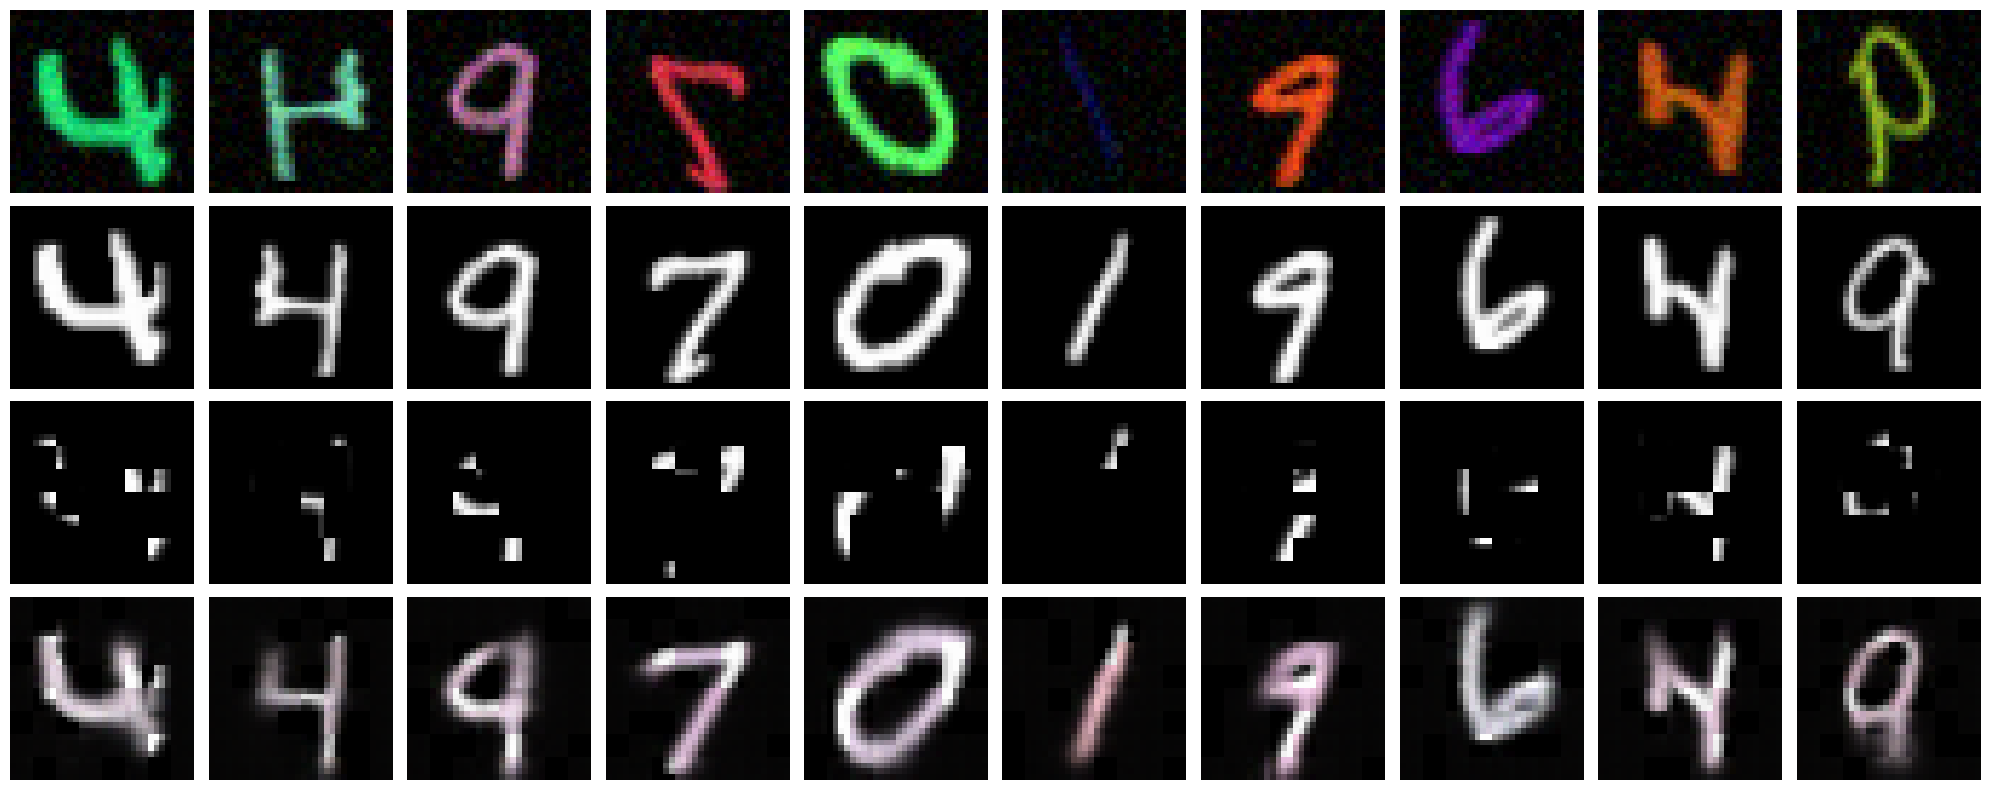


=== Visualizing FMNIST ===
Loading FashionMNIST to memory...
Loaded 60000 Train images and 10000 Test images to cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.016780395..0.92156863].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.024109844..0.9490196].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.0053856294..0.84313726].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.019221723..0.9490196].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.04893937..0.9764706].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010943465..0.9019608].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got ra

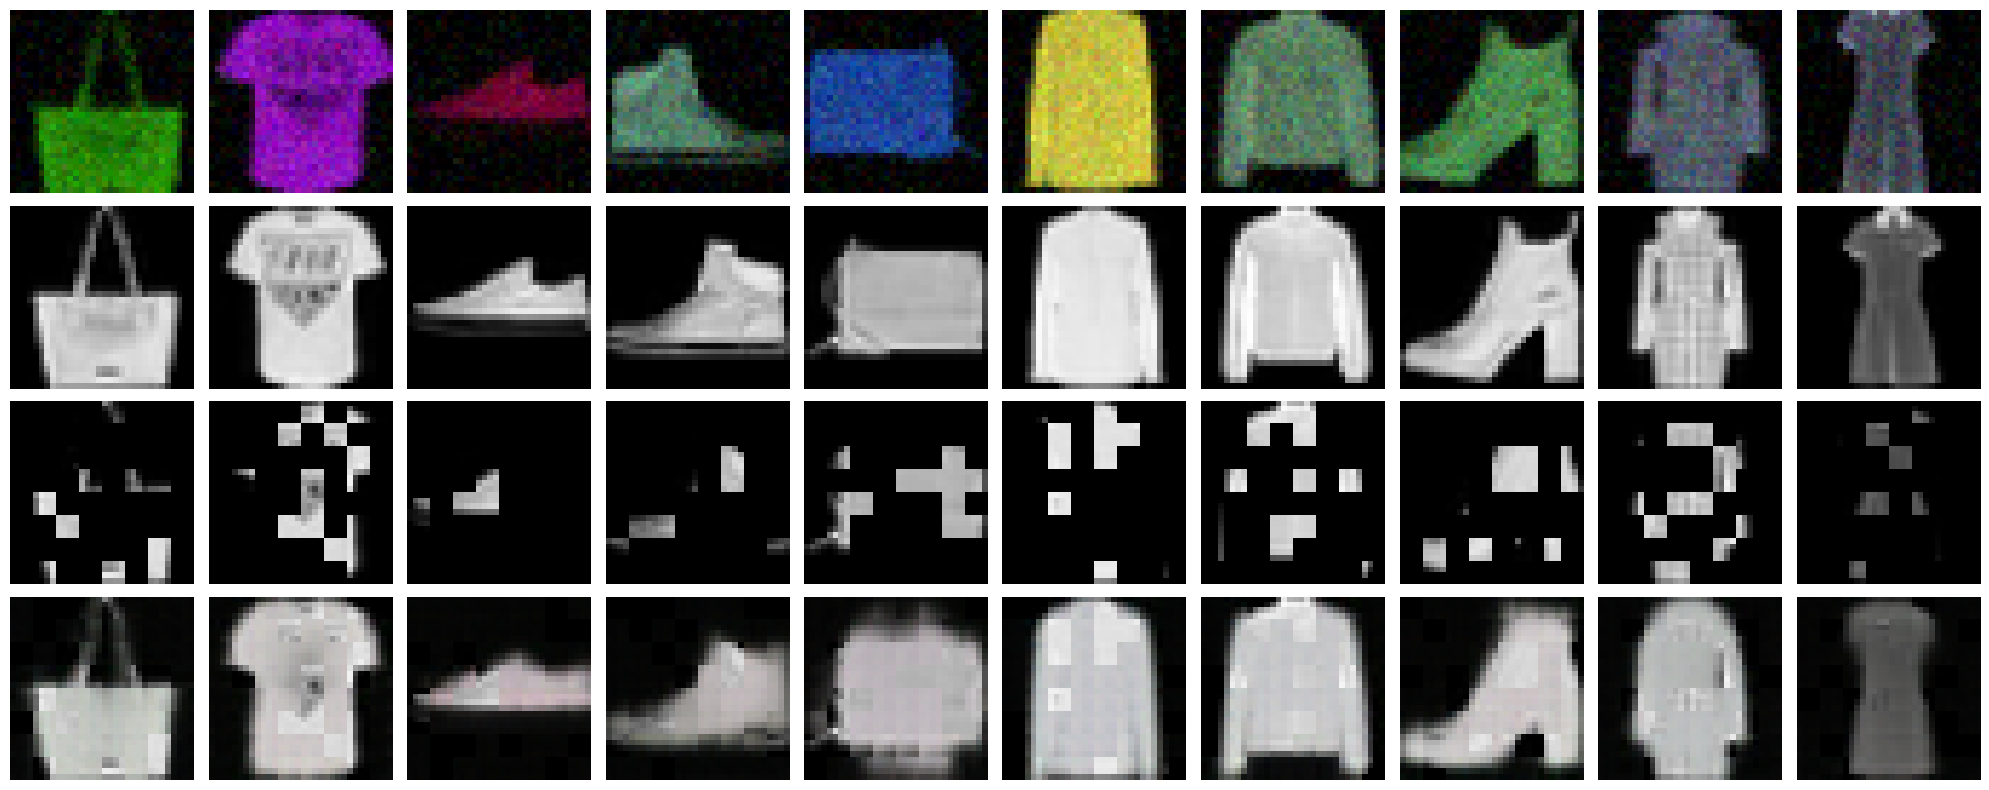


=== Visualizing CIFAR10 ===
Loading CIFAR-10 to memory...
Loaded 50000 Train images and 10000 Test images to cuda


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.14284305..1.0524937].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.041156292..1.0106739].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.02676677..1.0119519].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.010845229..0.90588236].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.037271142..0.9278481].


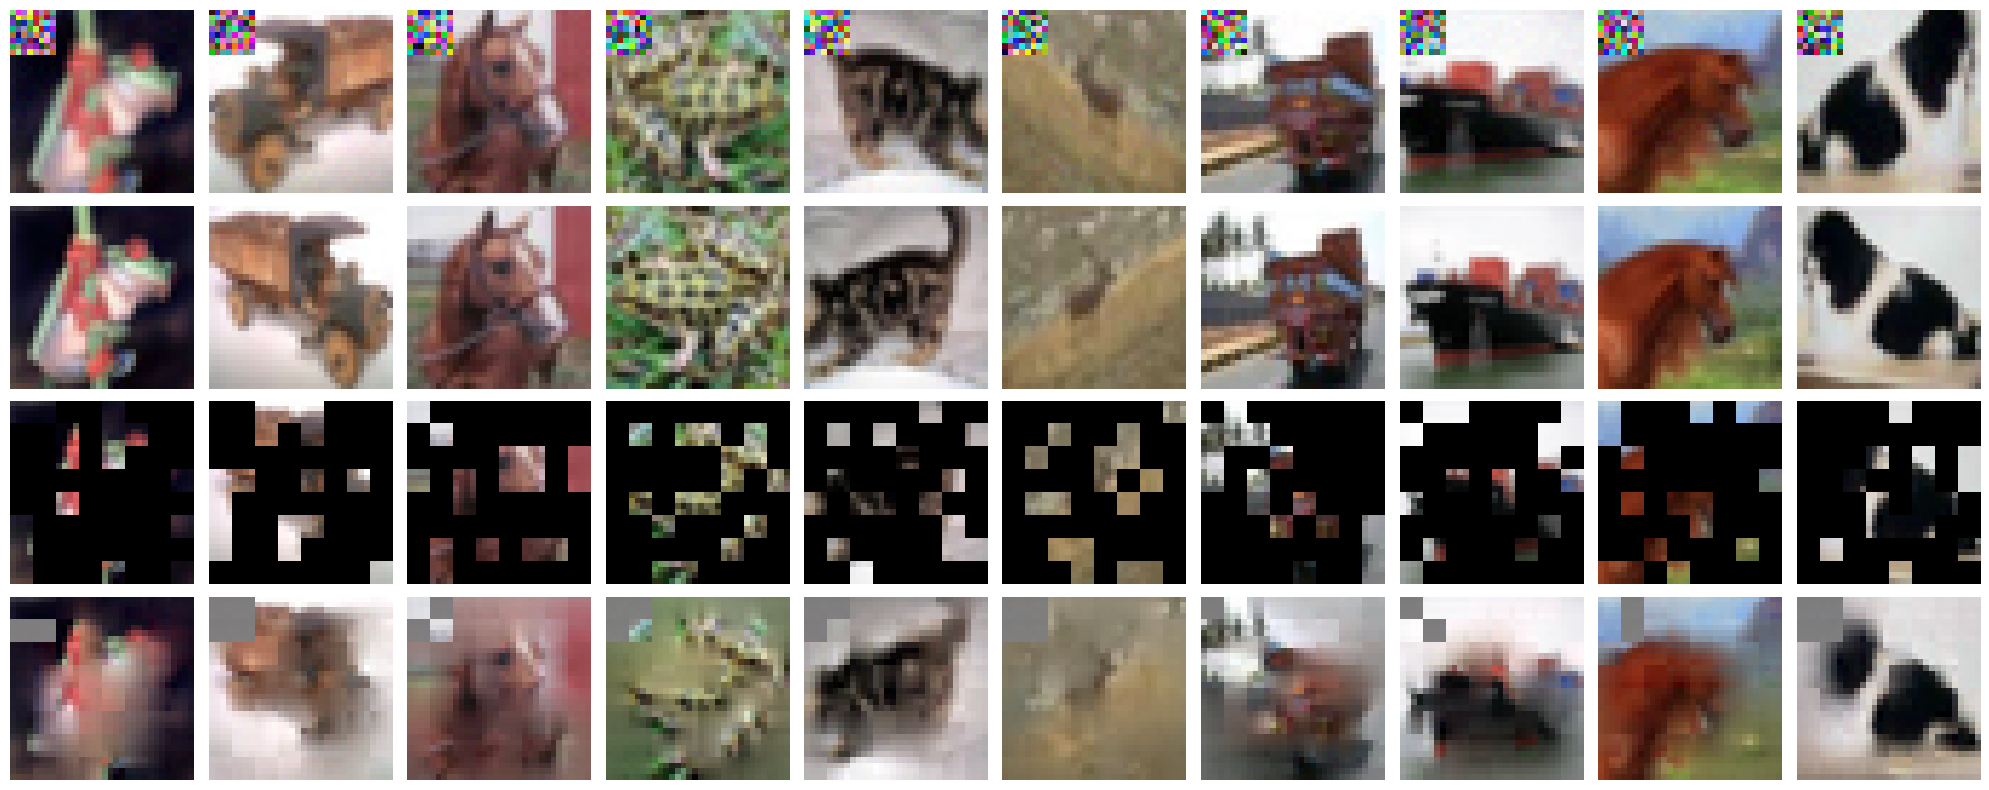

In [ ]:
# =========================================
# visualize MAE on test data with clean logic
# =========================================
import torch
import random
import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from models import MAEModel
from utils.shuffle import patchify, unpatchify

from loaders_wm import (
    ColoredMNISTLoader,
    ColoredFMNISTLoader,
    PatchedCIFARLoader,
)

# -------------------------------------------------
# device
# -------------------------------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"

# -------------------------------------------------
# augmentation functions (explicit, clean)
# -------------------------------------------------
def augment_colored_mnist(x_gray, color, augment, noise_std=0.05):
    """
    x_gray: (B,1,32,32)
    color : (B,3,1,1)
    """
    x = augment(x_gray)
    x = x.repeat(1, 3, 1, 1) * color
    x = x + torch.randn_like(x) * noise_std
    return torch.clamp(x, 0, 1)


def augment_patched_cifar(x_rgb, patch, augment, patch_size=8, noise_std=0.01):
    """
    x_rgb: (B,3,32,32)
    patch: (B,3,ps,ps)
    """
    x = augment(x_rgb)
    x = x.clone()
    x[:, :, :patch_size, :patch_size] = patch
    x = x + torch.randn_like(x) * noise_std
    return torch.clamp(x, 0, 1)


# -------------------------------------------------
# visualization
# -------------------------------------------------
def visualize_mae_test(
    model,
    task,
    dataset,
    loader,
    num_samples=8,
    img_size=32,
    patch_size=4,
):
    model.eval()
    model.to(device)

    idxs = random.sample(range(len(dataset)), num_samples)

    # ---- containers ----
    train_views = []
    raw_imgs = []
    visible_imgs = []
    recon_imgs = []

    for idx in idxs:
        # =========================
        # 1) raw test image
        # =========================
        x_raw, _ = dataset[idx]
        x_raw = x_raw.to(device)

        if task in ["mnist", "fmnist"]:
            x_gray = x_raw.unsqueeze(0)              # (1,1,32,32)
            x_rgb  = x_gray.repeat(1, 3, 1, 1)       # MAE input

            color = (
                loader.color_test_data[idx : idx + 1]
                if hasattr(loader, "color_test_data")
                else None
            )

            x_train = augment_colored_mnist(
                x_gray, color, loader.augment
            )

        elif task == "cifar10":
            x_rgb = x_raw.unsqueeze(0)                # (1,3,32,32)
            patch = loader.patch_test_data[idx : idx + 1]

            x_train = augment_patched_cifar(
                x_rgb, patch, loader.augment, loader.patch_size
            )

        else:
            raise NotImplementedError

        # =========================
        # 2) MAE forward (RAW ONLY)
        # =========================
        with torch.no_grad():
            pred, mask = model(x_rgb)

            tgt = patchify(x_rgb, patch_size)

            visible = unpatchify(
                tgt * (1 - mask.unsqueeze(-1)),
                img_size
            )

            recon = unpatchify(
                tgt * (1 - mask.unsqueeze(-1)) + pred * mask.unsqueeze(-1),
                img_size
            )

        # =========================
        # collect
        # =========================
        train_views.append(x_train[0].cpu())
        raw_imgs.append(x_rgb[0].cpu())
        visible_imgs.append(visible[0].cpu())
        recon_imgs.append(recon[0].cpu())

    # =========================
    # plot
    # =========================
    fig, axes = plt.subplots(4, num_samples, figsize=(2*num_samples, 8))

    for i in range(num_samples):
        axes[0, i].imshow(train_views[i].permute(1, 2, 0))
        axes[1, i].imshow(raw_imgs[i].permute(1, 2, 0))
        axes[2, i].imshow(visible_imgs[i].permute(1, 2, 0))
        axes[3, i].imshow(recon_imgs[i].permute(1, 2, 0))

        for r in range(4):
            axes[r, i].axis("off")

    axes[0, 0].set_ylabel("Train view", fontsize=12)
    axes[1, 0].set_ylabel("Raw test", fontsize=12)
    axes[2, 0].set_ylabel("MAE visible", fontsize=12)
    axes[3, 0].set_ylabel("MAE recon", fontsize=12)

    plt.tight_layout()
    plt.show()


# -------------------------------------------------
# run for all tasks
# -------------------------------------------------
tasks = ["mnist", "fmnist", "cifar10"]

for task in tasks:
    print(f"\n=== Visualizing {task.upper()} ===")

    model = MAEModel(
        img_size=32,
        patch_size=4,
        enc_dim=192,
        mask_ratio=0.75,
    ).to(device)

    model.encoder.load_state_dict(
        torch.load(f"./ckpt/mae_{task}_wm_encoder_192_37_last.pth")
    )
    model.decoder.load_state_dict(
        torch.load(f"./ckpt/mae_{task}_wm_decoder_192_37_last.pth")
    )

    if task == "mnist":
        ds = datasets.MNIST(
            root="../data",
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.Resize(32),
                transforms.ToTensor(),
            ]),
        )
        loader = ColoredMNISTLoader(batch_size=1, device=device)

    elif task == "fmnist":
        ds = datasets.FashionMNIST(
            root="../data",
            train=False,
            download=True,
            transform=transforms.Compose([
                transforms.Resize(32),
                transforms.ToTensor(),
            ]),
        )
        loader = ColoredFMNISTLoader(batch_size=1, device=device)

    elif task == "cifar10":
        ds = datasets.CIFAR10(
            root="../data",
            train=False,
            download=True,
            transform=transforms.ToTensor(),
        )
        loader = PatchedCIFARLoader(batch_size=1, device=device)

    visualize_mae_test(
        model,
        task,
        ds,
        loader,
        num_samples=10,
        img_size=32,
        patch_size=4,
    )
